In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
%cd "/content/drive/My Drive/sentiment_analysis_kaggle"
!ls

/content/drive/My Drive/sentiment_analysis_kaggle
glove.6B.100d.txt			sub3.csv
model1_weights.h5			sub4.csv
model3_weights.h5			sub5.csv
model4_weights.h5			sub_ensemble1.csv
model5_weights.h5			sub_shnn.csv
movie_review_sentiment_analysis1.ipynb	sub_xgb.csv
movie_review_sentiment_analysis2.ipynb	test.tsv
sampleSubmission.csv			train.tsv
sub1.csv


In [2]:
import numpy as np 
import pandas as pd 
import nltk
import os
import gc
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


In [0]:
train_df=pd.read_csv('train.tsv',sep='\t')
test_df=pd.read_csv('test.tsv',sep='\t')
sub=pd.read_csv('sampleSubmission.csv')

In [4]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
from string import punctuation
import re

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        #review=[stemmer.stem(w) for w in word_tokenize(str(review).lower())]
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus

In [0]:
train_df['clean_review']=clean_review(train_df.Phrase.values)
test_df['clean_review']=clean_review(test_df.Phrase.values)

In [7]:
train_text=train_df.clean_review.values
test_text=test_df.clean_review.values
target=train_df.Sentiment.values
y=to_categorical(target)
print(train_text.shape,test_text.shape,y.shape)

(156060,) (66292,) (156060, 5)


In [8]:
from collections import Counter
c = Counter( target )
print( c.items() )

dict_items([(1, 27273), (2, 79582), (3, 32927), (4, 9206), (0, 7072)])


In [9]:
X_train_text,X_val_text,y_train,y_val=train_test_split(train_text,y,test_size=0.3,random_state=123)

print(X_train_text.shape,X_val_text.shape)
print(y_train.shape,y_val.shape)

(109242,) (46818,)
(109242, 5) (46818, 5)


In [10]:
all_words=' '.join(X_train_text)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)
num_unique_word

13717

In [11]:
r_len=[]
for text in X_train_text:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)
MAX_REVIEW_LEN

48

In [12]:
max_features = num_unique_word
max_words = MAX_REVIEW_LEN
batch_size = 256
epochs = 5
num_classes=5

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train_text))
X_train = tokenizer.texts_to_sequences(X_train_text)
X_val = tokenizer.texts_to_sequences(X_val_text)
X_test = tokenizer.texts_to_sequences(test_text)

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_val.shape,X_test.shape)

(109242, 48) (46818, 48) (66292, 48)


In [0]:
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation

LSTM Model

In [0]:
visible1=Input(shape=(max_words,))
model1=Embedding(max_features,100,mask_zero=True)(visible1)
model1=LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True)(model1)
model1=LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False)(model1)
model1=Dense(64,activation='relu')(model1)


CNN Model

In [0]:
visible2=Input(shape=(max_words,))
model2=Embedding(max_features,100,input_length=max_words)(visible2)
model2=Dropout(0.2)(model2)
model2=Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1)(model2)
model2=GlobalMaxPooling1D()(model2)
model2=Dense(128,activation='relu')(model2)
model2=Dropout(0.2)(model2)
model2=Dense(64,activation='relu')(model2)

CNN+GRU Model

In [0]:
visible3=Input(shape=(max_words,))
model3=Embedding(max_features,100,input_length=max_words)(visible3)
model3=Conv1D(64,kernel_size=3,padding='same',activation='relu')(model3)
model3=MaxPooling1D(pool_size=2)(model3)
model3=Dropout(0.25)(model3)
model3=GRU(128,return_sequences=True)(model3)
model3=Dropout(0.3)(model3)
model3=Flatten()(model3)
model3=Dense(128,activation='relu')(model3)
model3=Dropout(0.5)(model3)
model3=Dense(64,activation='relu')(model3)

Bidirectional GRU Model

In [0]:
visible4=Input(shape=(max_words,))
model4=Embedding(max_features, 100, input_length=max_words)(visible4)
model4=SpatialDropout1D(0.25)(model4)
model4=Bidirectional(GRU(128))(model4)
model4=Dropout(0.5)(model4)
model4=Dense(64, activation='relu')(model4)

Glove word embedding Model

In [0]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features,embed_dim):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return embedding_matrix

In [19]:
EMBEDDING_FILE = 'glove.6B.100d.txt'
embed_dim = 100 #word vector dim
embedding_matrix = get_embed_mat(EMBEDDING_FILE,max_features,embed_dim)
print(embedding_matrix.shape)

Found 400000 word vectors.
(13717, 100)


In [0]:
visible5=Input(shape=(max_words,))
model5=Embedding(max_features, embed_dim, input_length=X_train.shape[1],weights=[embedding_matrix],trainable=True)(visible5)
model5=SpatialDropout1D(0.25)(model5)
model5=Bidirectional(GRU(128,return_sequences=True))(model5)
model5=Bidirectional(GRU(64,return_sequences=False))(model5)
model5=Dropout(0.5)(model5)
model5=Dense(64, activation='relu')(model5)

Merge all models. Note in previous attempts, XGBoost in 2nd stage with imbalanced classes(without attempting undersampling or oversampling) was not working well. 

In [0]:
from keras.layers.merge import concatenate

model = concatenate([model1, model2, model3, model4, model5], axis=1)
#model = concatenate([model, model3], axis=1)
#model = concatenate([model, model4], axis=1)
#model = concatenate([model, model5], axis=1)
#model=np.array(model)
#model = Conv1D(16,kernel_size=3,padding='same',activation='relu',strides=1)(model)
#model = Conv1D(32,kernel_size=3,padding='same',activation='relu',strides=1)(model)
#model = Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1)(model)
#model=GlobalMaxPooling1D()(model)
#model=Flatten()(model)
model=Dense(4096,activation='relu')(model)
model=BatchNormalization()(model)
model=Dropout(0.3)(model)
model=Dense(1024,activation='relu')(model)
model=BatchNormalization()(model)
model=Dropout(0.3)(model)
model=Dense(512,activation='relu')(model)
model=BatchNormalization()(model)
model=Dropout(0.3)(model)
output=Dense(5,activation='softmax')(model)

In [22]:
model_concat = Model(inputs=[visible1, visible2, visible3, visible4, visible5], outputs=output)
model_concat.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_concat.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 48)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 48, 100)      1371700     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 48, 64)       19264       embedding_3[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 48)           0                                            
__________________________________________________________________________________________________
max_poolin

In [23]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
callbacks = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto')
best_model_file = "best_model_weights.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

history=model_concat.fit([X_train, X_train, X_train, X_train, X_train], y_train, validation_data=([X_val, X_val, X_val, X_val, X_val], y_val),epochs=5, batch_size=batch_size, verbose=1, callbacks = [callbacks,best_model])

Train on 109242 samples, validate on 46818 samples
Epoch 1/5
109242/109242 [==============================] - 406s 4ms/step - loss: 1.2162 - acc: 0.5338 - val_loss: 0.8883 - val_acc: 0.6360

Epoch 00001: val_acc improved from -inf to 0.63602, saving model to best_model_weights.h5
Epoch 2/5
109242/109242 [==============================] - 395s 4ms/step - loss: 0.8241 - acc: 0.6652 - val_loss: 0.8107 - val_acc: 0.6657

Epoch 00002: val_acc improved from 0.63602 to 0.66573, saving model to best_model_weights.h5
Epoch 3/5
109242/109242 [==============================] - 393s 4ms/step - loss: 0.7224 - acc: 0.7043 - val_loss: 0.8347 - val_acc: 0.6699

Epoch 00003: val_acc improved from 0.66573 to 0.66991, saving model to best_model_weights.h5
Epoch 00003: early stopping


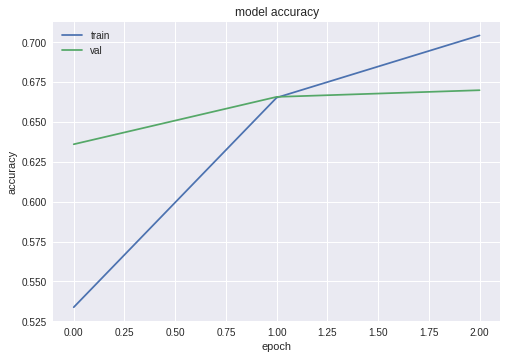

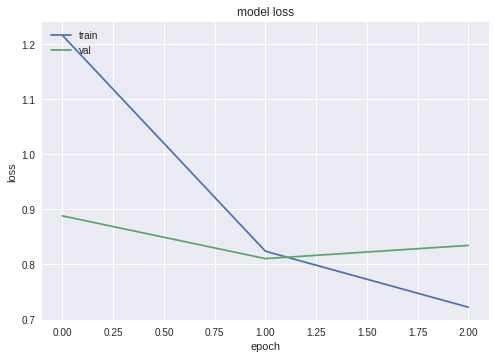

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
model_concat.load_weights('best_model_weights.h5')

In [25]:
y_pred=model_concat.predict([X_test, X_test, X_test, X_test, X_test], verbose=1)

66292/66292 [==============================] - 630s 10ms/step


In [28]:
y_pred=np.argmax(y_pred, axis = 1)
print(y_pred.shape)

from collections import Counter
c = Counter( y_pred )
print( c.items() )

(66292,)
dict_items([(3, 10907), (2, 43004), (1, 9539), (4, 1608), (0, 1234)])


In [29]:
sub.Sentiment=y_pred
sub.to_csv('sub_ensemble1.csv',index=False)
sub.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,2
